# Using Known text attack to identity XOR obsfuscation keys

In this notebook, we use two approach to run known text attack (KT attacks) against the firmware files.
 1. Run an heuristic that assumes the most prevalent byte value is 0x00
 2. Run a real KT attack on sections of the files that alternate between 0xff and 0x00 values

But first we need to look at the structure of the firmware files.

## Firmware files structure

In [9]:
%run ThetaS.ipynb
!ls -sh firmwares/*.frm

5,0M firmwares/ap1_v110.frm  6,2M firmwares/gy1_v121.frm
5,0M firmwares/ap1_v130.frm  6,2M firmwares/gy1_v130.frm
5,0M firmwares/ap1_v131.frm


We have 5 files, 3 for theta m15 and 2 for the theta S

In each file we can see a part delimitor 'UNITY FILE V1.10'.

The part header seem to be 0x800 bytes long. Then XOR obfuscation starts.

In [10]:
# break the firmware in their two parts
import os, mmap
firmwares = ["ap1_v110.frm", "ap1_v130.frm", "ap1_v131.frm", "gy1_v121.frm", "gy1_v130.frm"]
for f in firmwares:
    fname = os.path.sep.join(['firmwares', f])
    with open(fname, "rb") as fin:
        partnum = 1
        s = mmap.mmap(fin.fileno(), 0 , access = mmap.ACCESS_READ)
        last = i = s.find('UNITY', 0)
        while i >= 0:
            # print f, i
            i = s.find('UNITY', i+1)
            outname = os.path.sep.join(['firmwares', 'parts', f])
            with open("%s.part%d" % (outname, partnum), "wb") as fout:
                fout.write(s[last:i])
                last = i
                partnum += 1
        s.close()
!ls -sh firmwares/parts/*.part[1,2]

2,7M firmwares/parts/ap1_v110.frm.part1
2,3M firmwares/parts/ap1_v110.frm.part2
2,7M firmwares/parts/ap1_v130.frm.part1
2,4M firmwares/parts/ap1_v130.frm.part2
2,7M firmwares/parts/ap1_v131.frm.part1
2,4M firmwares/parts/ap1_v131.frm.part2
3,6M firmwares/parts/gy1_v121.frm.part1
2,6M firmwares/parts/gy1_v121.frm.part2
3,6M firmwares/parts/gy1_v130.frm.part1
2,6M firmwares/parts/gy1_v130.frm.part2


We have 5 firmwares
3 for m15 and 2 for S
we can see that 
- there are section in these files with very low entropy (see below)
- we verified that the same XOR keys generator is used for both version of product.
- we verified these low entropy sections to be alternatinf 0x380 blocks of 0x00 and 0xff.


In [11]:
# the firmware
firmwares = ["ap1_v110.frm", "ap1_v130.frm", "ap1_v131.frm", "gy1_v121.frm", "gy1_v130.frm"]
simple_filenames = [f+'.part1' for f in firmwares] + [f+'.part2' for f in firmwares]
filenames = [os.path.sep.join(['firmwares', 'parts', f]) for f in simple_filenames]

firmwares_parts = dict([(os.path.basename(fname),FirmwarePart(fname)) for fname in filenames])
firmwares_parts_m15 = dict([(fname, part) for fname, part in firmwares_parts.items() if "ap1" in fname])
firmwares_parts_s = dict([(fname, part) for fname, part in firmwares_parts.items() if "gy1" in fname])

for x in firmwares_parts.values():
    print x

<Part 'gy1_v121.frm.part2', size: 0x00286000
 embed:	SubPart y02firm8 size:0x285654 >
<Part 'gy1_v130.frm.part1', size: 0x00619e00
 embed:	SubPart y02firm6 size:0x393580
	SubPart gy1_v130up size:0x286000 >
<Part 'gy1_v130.frm.part2', size: 0x00286000
 embed:	SubPart y02firm8 size:0x285654 >
<Part 'gy1_v121.frm.part1', size: 0x00619e00
 embed:	SubPart y02firm6 size:0x393580
	SubPart gy1_v121up size:0x286000 >
<Part 'ap1_v130.frm.part2', size: 0x0024dc00
 embed:	SubPart z01firm8 size:0x24d254 >
<Part 'ap1_v130.frm.part1', size: 0x004f3800
 embed:	SubPart z01firm6 size:0x2a5240
	SubPart ap1_v130up size:0x24dc00 >
<Part 'ap1_v110.frm.part1', size: 0x004ef400
 embed:	SubPart z01firm6 size:0x2a5240
	SubPart ap1_v110up size:0x249800 >
<Part 'ap1_v110.frm.part2', size: 0x00249800
 embed:	SubPart z01firm8 size:0x248e54 >
<Part 'ap1_v131.frm.part2', size: 0x0024dc00
 embed:	SubPart z01firm8 size:0x24d254 >
<Part 'ap1_v131.frm.part1', size: 0x004f3800
 embed:	SubPart z01firm6 size:0x2a5240
	SubPa

## XOR key heuristic based on NULL values

The first heuristic is too pretend that the most common byte value is 0x00. The function find_xor_key_3 is the heuristic implementation.

In [12]:
# apply find_xor_key_3 xor heuristic to all section in memory
for fname, firm in firmwares_parts.items():
    print fname,"...",
    firm.search_xor_keys(find_xor_key_3)
    unxor_fname = os.path.sep.join(['firmwares', 'unxor', fname])
    firm.write_to_file(unxor_fname+'.unxor.orig')
    # firm.apply_xor(keys)
    fullname = os.path.sep.join(['firmwares', 'keys', fname])
    key_manager.add_keys(fname, firm.get_section_keys())
    # save keys to file
    key_manager.save_keys_to_file(fname, fname)

gy1_v121.frm.part2 ... 5164 sections/keys and 5164 distinct keys
wrote 5164 keys to firmwares/keys/gy1_v121.frm.part2.pkeys
gy1_v130.frm.part1 ... 7323 sections/keys and 7323 distinct keys
wrote 7323 keys to firmwares/keys/gy1_v130.frm.part1.pkeys
gy1_v130.frm.part2 ... 5164 sections/keys and 5164 distinct keys
wrote 5164 keys to firmwares/keys/gy1_v130.frm.part2.pkeys
gy1_v121.frm.part1 ... 7323 sections/keys and 7323 distinct keys
wrote 7323 keys to firmwares/keys/gy1_v121.frm.part1.pkeys
ap1_v130.frm.part2 ... 4714 sections/keys and 4714 distinct keys
wrote 4714 keys to firmwares/keys/ap1_v130.frm.part2.pkeys
ap1_v130.frm.part1 ... 5418 sections/keys and 5418 distinct keys
wrote 5418 keys to firmwares/keys/ap1_v130.frm.part1.pkeys
ap1_v110.frm.part1 ... 5418 sections/keys and 5418 distinct keys
wrote 5418 keys to firmwares/keys/ap1_v110.frm.part1.pkeys
ap1_v110.frm.part2 ... 4680 sections/keys and 4680 distinct keys
wrote 4680 keys to firmwares/keys/ap1_v110.frm.part2.pkeys
ap1_v131

## KT attacks gain low entropy sections of alternating 0x00 0xff

In this heuristic, we will looks at low entropy sections of the firmware. The sections, in both the m15 and the theta S, are composed of alternating blocks of 0x380 bytes of 0xff or 0x00 bytes

Ricoh M15 Firmwares part
Low entropy from 0x9b0a0 -> 0x15e2a0 # 620 kB-> 1400 kB


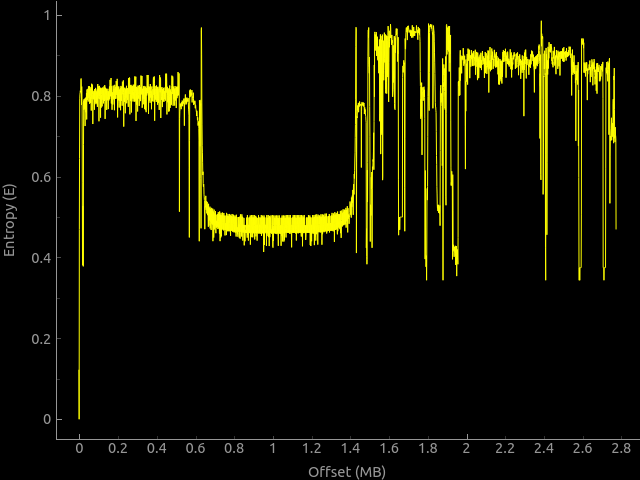

In [13]:
import collections
# the alternating 0x00, 0xff blocks indexes
alt_blocks = {}
# show entropy from binwalk
from IPython.display import Image
# 0x99e00 starts a section of 0x00 for 0x580 bytes
# M15 firmware low entropy section.
# 0x99e00 -> 0x158000+ is a good know text attack
# most easy from 0x9d000-> 0x158000+
# we _know_ that 0xf98a0 is a start of block (00)
known_good_start = 0xf98a0
supposed_start = 0x9ae00
start_blocks_addr = [i for i in range(known_good_start, supposed_start, -0x380)][-1]
# part2 confirms with clear text at 0x9b7e0
# finishing is not confirmed. Its weird down there.
supposed_stop = 0x15e600
stop_blocks_addr = [i for i in range(known_good_start, supposed_stop, 0x380)][-1]
# print hex(stop_blocks_addr) # 0x15e2a0
print "Ricoh M15 Firmwares part\nLow entropy from 0x%x -> 0x%x # %d kB-> %d kB" % (start_blocks_addr, stop_blocks_addr, start_blocks_addr/1024, stop_blocks_addr/1024)
alt_blocks['m15'] = (start_blocks_addr, stop_blocks_addr)
# entropy.png was generated from binwalk
Image(filename='firmwares/parts/entropy.ap1_v110.frm.part1.png')

Ricoh Theta S Firmware Parts
Low entropy from 0x17c0b0 -> 0x23ddb0 # 1520 kB-> 2295 kB


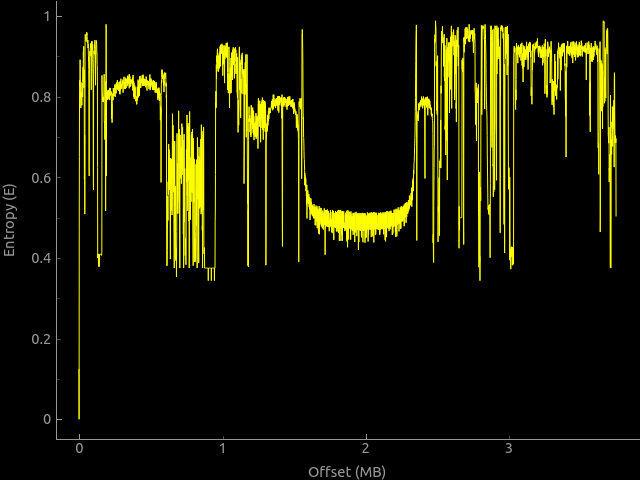

In [14]:
# MS firmware low entropy section.
ap1_v130p1 = firmwares_parts['ap1_v130.frm.part1']
ap1_v130p2 = firmwares_parts['ap1_v130.frm.part2']
gy1_v121p1 = firmwares_parts['gy1_v121.frm.part1']
gy1_v121p2 = firmwares_parts['gy1_v121.frm.part2']

# low entropy at 0x95800->0xe8e00, probably a lot of Null bytes.
# 0x0017be00 starts a 0x380 section of 0x00. 
# then the pattern of alternating 0x380 blocks
# -> 0023e000

# good decryption in part2
known_good_start = 0x00185ab0
# print "start at 0x%x end expected at 0x%x" %(known_good_start, (0x185ab0 + 0x380)) #
supposed_start = 0x0017c000
start_blocks_addr = [i for i in range(known_good_start, supposed_start, -0x380)][-1]

# finishing is not confirmed. Its weird down there.
supposed_stop = 0x23e000
stop_blocks_addr = [i for i in range(known_good_start, supposed_stop, 0x380)][-1]
#print "start at 0x%x end expected at 0x%x" %(known_good_start, (0x185ab0 + 0x380)) #

print "Ricoh Theta S Firmware Parts\nLow entropy from 0x%x -> 0x%x # %d kB-> %d kB" % (start_blocks_addr, stop_blocks_addr, start_blocks_addr/1024, stop_blocks_addr/1024)
alt_blocks['s'] = (start_blocks_addr, stop_blocks_addr)
Image(filename='firmwares/parts/entropy.gy1_v130.frm.part1.png')

In [15]:
# TODO SANDBOX
# use the alternating pattern of part1.
# 0x99e00 -> 0x158000+ is a good know text attack
# most easy from 0x9d000-> 0x158000+
# change_key (, '4b0f08fe') # kt @0x9d000

# we have a very good pattern match vfor bit1, Except at 0x000d4600 +0x200*32 (0x000d8600)
if False:
    addr = 0x38800
    print 
    s1 = firmwares_parts['gy1_v121.frm.part1']
    s2 = firmwares_parts['gy1_v121.frm.part2']
    if False:
        print hexdump_kt(s1[addr], s2[addr], addr)
        addr += 0x200
        print hexdump_kt(s1[addr], s2[addr], addr)
        addr += 0x200
        print hexdump_kt(s1[addr], s2[addr], addr)
    else:
        s1, s2, c = comp_at(s1, s2, addr)
        #s1.reset_xor(find_xor_key_3)
        #s2.reset_xor(find_xor_key_3)
        #print try_reverse_key(s1)
        #print try_reverse_key(s1, 'fefefefe')
        print try_key(s2, 'a2dd405c')
        #s1, s2, c = comp_at(ap1_v130p1, ap1_v130p2, 0x000f9a00)


In [16]:
def kt_attack_alt_0f_blocks(start_address, stop_address, kt_firmware, firm_list):
    ''' Runs a known text attack on low entropy sections of the firmware parts.
    '''
    # we know there are blocks of favorable 0x00 then 0xff
    # we look at each block, and find_xor for the most common word in that block, in that section.
    # taking in account that block can overlap two section (different xor keys between sections)
    # we weight each key, and take the most promising for that section.
    block_length = 0x380
    
    kt_keys_2 = collections.defaultdict(list)

    # for addr in range(0xf98a0, 0x000fb200, block_length): # works
    # for addr in range(0xb9000, 0xba000, block_length):
    # for addr in range(0x9d020, 0xad000, block_length): # works
    # for addr in range(start_blocks_addr, start_blocks_addr+0x1000, block_length):
    # for addr in range(stop_blocks_addr1, stop_blocks_addr, block_length):

    for addr in range(start_address, stop_address, block_length):    
        section_start = kt_firmware[addr]._start
        block_start = addr
        ## print "Block start:", hex(addr), "Section Start:", hex(section_start)

        # we expected that the most common xor key will be 
        pt = '\x00\x00\x00\x00'
        # for addr-> min(addr+0x1c0, end_ofsection)
        start = addr
        target_end = addr+0x1c0
        end_section = section_start + kt_firmware[start]._length
        end = min(end_section, target_end)
        if target_end == end:
            # block is not between section
            hkey1, stats = kt_firmware.search_xor_keys_by_addr(find_xor_key, start, end)
            weight1 = float(end-start)/block_length
            kt_keys_2[section_start].append((weight1,hkey1))
            ## print "kt_keys[0x%x] = %s # kt blocks 1 analysis (0x00) at @0x%x weight:%0.2f" % (section_start, hkey1, start, weight1) 
        else:
            # block is between section
            next_section_start = kt_firmware[target_end]._start
            hkey1, stats1 = kt_firmware.search_xor_keys_by_addr(find_xor_key, start, end)
            hkey12, stats12 = kt_firmware.search_xor_keys_by_addr(find_xor_key, end, target_end)
            # we have to merge stats12 with the below stats2
            weight1 = float(end-start)/block_length
            weight12 = float(target_end-end)/block_length
            kt_keys_2[section_start].append((weight1,hkey1))
            kt_keys_2[next_section_start].append((weight12,hkey12))
            ## print "kt_keys[0x%x] = %s # kt blocks 1 analysis (0x00) at @0x%x weight:%0.2f" % (section_start, hkey1, start, weight1) 
            ## print "kt_keys[0x%x] = %s # kt blocks 1.2 analysis (0x00) at @0x%x weight:%0.2f" % (next_section_start, hkey12, start, weight12) 

        ## look for 
        pt = '\xff\xff\xff\xff'
        start = addr+0x1c0
        section_start = kt_firmware[start]._start
        target_end = addr+0x380
        end_section = section_start + kt_firmware[start]._length
        end = min(end_section, target_end)
        if target_end == end:
            # block is not between section
            hkey2, stats2 = kt_firmware.search_xor_keys_by_addr(find_xor_key, start, end)
            hkey2 = hkey_reverse(hkey2)
            weight2 = float(end-start)/block_length
            kt_keys_2[section_start].append((weight2,hkey2))
            ## print "kt_keys[0x%x] = %s # kt blocks 2 analysis (0xff) at @0x%x weight:%0.2f" % (section_start, hkey2, start, weight2) 
        else:
            # block is between section
            next_section_start = kt_firmware[target_end]._start
            hkey2, stats2 = kt_firmware.search_xor_keys_by_addr(find_xor_key, start, end)
            hkey22, stats22 = kt_firmware.search_xor_keys_by_addr(find_xor_key, end, target_end)
            hkey2 = hkey_reverse(hkey2)
            hkey22 = hkey_reverse(hkey22)
            weight2 = float(end-start)/block_length
            weight22 = float(target_end-end)/block_length
            kt_keys_2[section_start].append((weight2,hkey2))
            kt_keys_2[next_section_start].append((weight22,hkey22))
            ## print "kt_keys[0x%x] = %s # kt blocks 2 analysis (0xff) at @0x%x weight:%0.2f" % (section_start, hkey2, start, weight2) 
            ## print "kt_keys[0x%x] = %s # kt blocks 2.2 analysis (0xff) at @0x%x weight:%0.2f" % (next_section_start, hkey22, start, weight22) 

    # sort by address
    kt_keys = kt_keys_2.items()
    kt_keys.sort(key=lambda x: x[0])
    for addr, wkeys in kt_keys:
        # add similar key's weight
        weights = collections.defaultdict(float)
        for weight, hkey in wkeys:
            weights[hkey] += weight
        weights = weights.items()
        # sort by weight
        weights.sort(key=lambda x:x[1], reverse=True)
        hkey = weights[0][0]
        i = get_i_from_address(addr)
        ## print change_string(i, hkey, addr, r='kt blocks')
        for firm in firm_list:
            try:
                firm[addr].xor(binascii.unhexlify(hkey))
            except IndexError:
                pass
    start_i = get_i_from_address(kt_keys[0][0])
    stop_i = get_i_from_address(kt_keys[-1][0])
    print "%d keys updated from 0x%x (%d) to 0x%x (%d) in %s" % (len(kt_keys), start_address, start_i, stop_address, stop_i, kt_firmware.name)
    # DEBUG
    # for addr, hkey in kt_keys:
    #     print hexdump_kt(ap1_v130p1[addr], ap1_v130p2[addr], addr)
    return

# run the KT attack from m15 firmwares KT to all firmwares
start_blocks_addr, stop_blocks_addr = alt_blocks['m15']
kt_attack_alt_0f_blocks(start_blocks_addr, stop_blocks_addr, ap1_v130p1, firmwares_parts_m15.values() + firmwares_parts_s.values())
start_blocks_addr, stop_blocks_addr = alt_blocks['s']
kt_attack_alt_0f_blocks(start_blocks_addr, stop_blocks_addr, gy1_v121p1, firmwares_parts_m15.values() + firmwares_parts_s.values())

# update our key store
for fname, firm in firmwares_parts.items():
    key_manager.add_keys(fname, firm.get_section_keys())


1562 keys updated from 0x9b0a0 (1236) to 0x15e2a0 (2797) in ap1_v130.frm.part1
1551 keys updated from 0x17c0b0 (3036) to 0x23ddb0 (4586) in gy1_v121.frm.part1
KeyManager: replacing key list for  gy1_v121.frm.part2
KeyManager: replacing key list for  gy1_v130.frm.part1
KeyManager: replacing key list for  gy1_v130.frm.part2
KeyManager: replacing key list for  gy1_v121.frm.part1
KeyManager: replacing key list for  ap1_v130.frm.part2
KeyManager: replacing key list for  ap1_v130.frm.part1
KeyManager: replacing key list for  ap1_v110.frm.part1
KeyManager: replacing key list for  ap1_v110.frm.part2
KeyManager: replacing key list for  ap1_v131.frm.part2
KeyManager: replacing key list for  ap1_v131.frm.part1


## Merging both heuristic

The heuristic have been applied to all firmwares files. We merge results by choosing the most common key used at each section across all firmwares parts.

In [17]:
# read all keys, take the most common key shared by all firmware parts
# we will call that list the consensus list, from our xor heuristic + KT attack.
consensus_keys = []
consensus_alt = []
keylist_names = key_manager.keylist.keys()
for i in range(0, len(key_manager.get_keys('gy1_v130.frm.part1'))):
    _keys = []
    for fname in keylist_names:
        temp_keylist = key_manager.get_keys(fname)
        if len(temp_keylist) > i:
            _keys.append(temp_keylist[i])
    consensus_keys.append(collections.Counter(_keys).most_common(1)[0][0])
    consensus_alt.append(collections.Counter(_keys))
#
key_manager.add_keys('consensus', consensus_keys)
# save keys to file
nb, fname = key_manager.save_keys_to_file('consensus', 'consensus')
print 'Consensus keys: %d keys save to %s' % (len(consensus_keys), fname)


wrote 7323 keys to firmwares/keys/consensus.pkeys
Consensus keys: 7323 keys save to firmwares/keys/consensus.pkeys


In [18]:
# save the previous unxor to file
for fname, firm in firmwares_parts.items():
    print fname, "...",
    firm.apply_xor(key_manager.get_keys('consensus'))
    unxor_filename = os.path.sep.join(['firmwares', 'unxor', fname]) + '.unxor.2'
    firm.write_to_file(unxor_filename)
    print 'wrote to', unxor_filename

gy1_v121.frm.part2 ... 5164/5164 sections Xor-ed
wrote to firmwares/unxor/gy1_v121.frm.part2.unxor.2
gy1_v130.frm.part1 ... 7323/7323 sections Xor-ed
wrote to firmwares/unxor/gy1_v130.frm.part1.unxor.2
gy1_v130.frm.part2 ... 5164/5164 sections Xor-ed
wrote to firmwares/unxor/gy1_v130.frm.part2.unxor.2
gy1_v121.frm.part1 ... 7323/7323 sections Xor-ed
wrote to firmwares/unxor/gy1_v121.frm.part1.unxor.2
ap1_v130.frm.part2 ... 4714/4714 sections Xor-ed
wrote to firmwares/unxor/ap1_v130.frm.part2.unxor.2
ap1_v130.frm.part1 ... 5418/5418 sections Xor-ed
wrote to firmwares/unxor/ap1_v130.frm.part1.unxor.2
ap1_v110.frm.part1 ... 5418/5418 sections Xor-ed
wrote to firmwares/unxor/ap1_v110.frm.part1.unxor.2
ap1_v110.frm.part2 ... 4680/4680 sections Xor-ed
wrote to firmwares/unxor/ap1_v110.frm.part2.unxor.2
ap1_v131.frm.part2 ... 4714/4714 sections Xor-ed
wrote to firmwares/unxor/ap1_v131.frm.part2.unxor.2
ap1_v131.frm.part1 ... 5418/5418 sections Xor-ed
wrote to firmwares/unxor/ap1_v131.frm.part

In [19]:
# TODO send to sandbox
# depends on consensus_keys, consensus_alt
if False:
    # show alternate keys for address.
    address = 0x186e00
    for fname, firm in firmwares_parts.items():
        if address <= len(firm):
            previously, _ = firm.search_xor_keys_by_addr(find_xor_key, address, address+0x200)
            i = get_i_from_address(address)
            consensus = consensus_keys[i]
            print fname, "key:" , firm[address].hex_key, "previous autokey:", previously, "rev:",hkey_reverse(previously), "cons:", consensus
    final_i = get_i_from_address(address)
    print consensus_alt[final_i]

    # ap1_v130.frm.part2.unxor.2 seems to disagree on 0x189800 key given by kt_attack_alt_0f_blocks
    # TODO use kt_attack_alt_0f_blocks on easy KT, but on all part1 individually as KT.
    k2 = '2d736b6a'
    for firm in firmwares_parts.values():
        print firm.name
        #try_key(firm[address], k2)
